In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [156]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [157]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [158]:
print("\nInformación del conjunto de datos de ratings:")
print(f"Número de valoraciones: {len(ratings)}")
print(f"Número de usuarios únicos: {ratings['userId'].nunique()}")
print(f"Número de películas valoradas: {ratings['movieId'].nunique()}")
print("\nEjemplo de ratings:")
print(ratings.head())


Información del conjunto de datos de ratings:
Número de valoraciones: 100836
Número de usuarios únicos: 610
Número de películas valoradas: 9724

Ejemplo de ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [159]:
print("\nInformación del conjunto de datos de películas:")
print(f"Número total de películas: {len(movies)}")
print("\nEjemplo de películas:")
print(movies.head())


Información del conjunto de datos de películas:
Número total de películas: 9742

Ejemplo de películas:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  



Estadísticas de valoraciones:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Creando tabla de usuario-película...
Dimensiones de la tabla pivote: (610, 9724)

Primeras 5 filas y columnas):
movieId    1    2    3    4    5
userId                          
1        4.0  0.0  4.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0


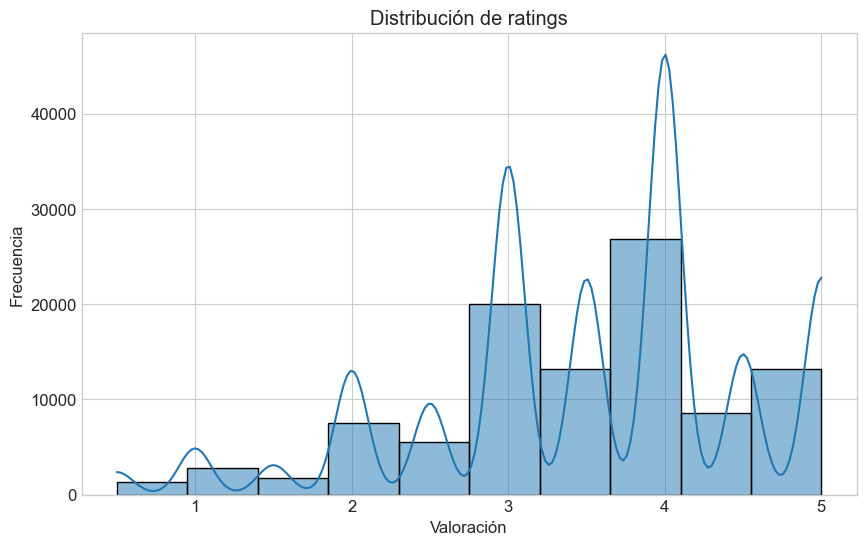

In [160]:
print("\nEstadísticas de valoraciones:")
print(ratings['rating'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribución de ratings')
plt.xlabel('Valoración')
plt.ylabel('Frecuencia')
plt.savefig('distribucion_valoraciones.png')

print("\nCreando tabla de usuario-película...")
tabla = pd.pivot_table(ratings, index='userId', columns='movieId', values='rating', fill_value=0)
print(f"Dimensiones de la tabla pivote: {tabla.shape}")
print("\nPrimeras 5 filas y columnas):")
print(tabla.iloc[:5, :5])

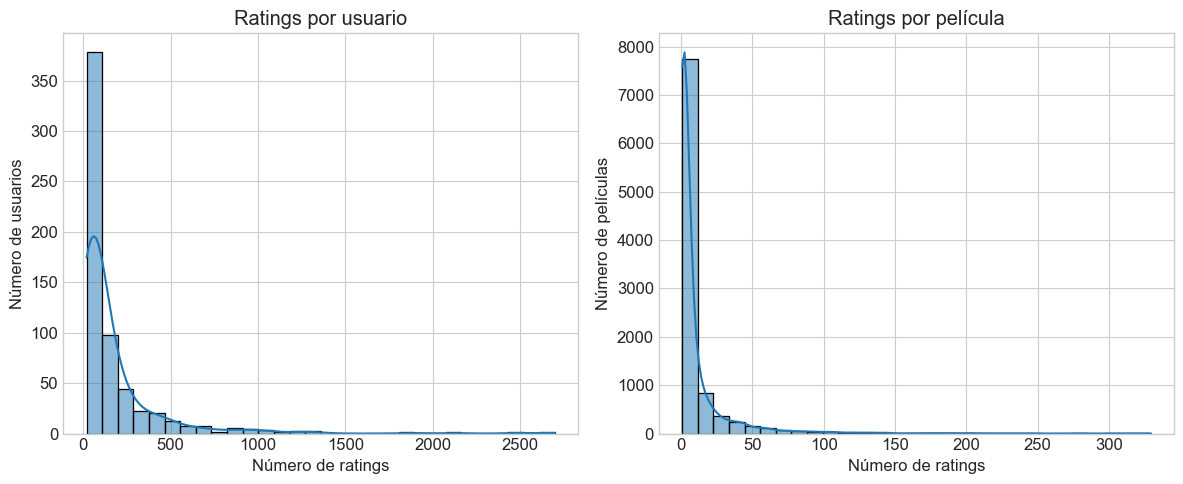

In [162]:
valoraciones_por_usuario = ratings.groupby('userId').size()
valoraciones_por_pelicula = ratings.groupby('movieId').size()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(valoraciones_por_usuario, bins=30, kde=True)
plt.title('Ratings por usuario')
plt.xlabel('Número de ratings')
plt.ylabel('Número de usuarios')

plt.subplot(1, 2, 2)
sns.histplot(valoraciones_por_pelicula, bins=30, kde=True)
plt.title('Ratings por película')
plt.xlabel('Número de ratings')
plt.ylabel('Número de películas')
plt.tight_layout()
plt.savefig('distribuciones_valoraciones.png')


In [166]:
MIN_MOVIE_RATINGS = 50
MIN_USER_RATINGS = 20 

peliculas_populares = valoraciones_por_pelicula[valoraciones_por_pelicula >= MIN_MOVIE_RATINGS].index
usuarios_activos = valoraciones_por_usuario[valoraciones_por_usuario >= MIN_USER_RATINGS].index

ratings_filtered = ratings[
    (ratings['movieId'].isin(peliculas_populares)) & 
    (ratings['userId'].isin(usuarios_activos))
]

In [167]:
print(f"\nDespués de filtrar, quedaron {len(ratings_filtered)} ratings")
print(f"Usuarios activos: {len(usuarios_activos)}")
print(f"Películas populares: {len(peliculas_populares)}")

tabla_filtrada = pd.pivot_table(
    ratings_filtered, 
    index='userId', 
    columns='movieId', 
    values='rating', 
    fill_value=0
)

print(f"Dimensiones de la tabla filtrada: {tabla_filtrada.shape}")


Después de filtrar, quedaron 41360 ratings
Usuarios activos: 610
Películas populares: 450
Dimensiones de la tabla filtrada: (606, 450)


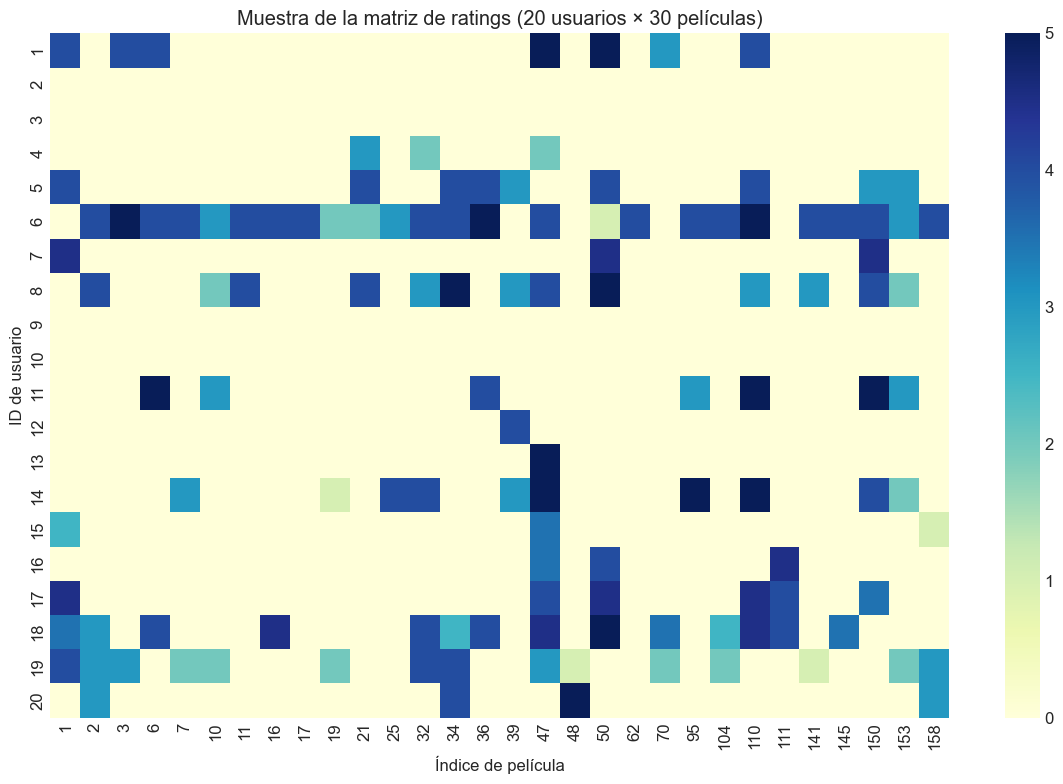

In [168]:
plt.figure(figsize=(12, 8))
sns.heatmap(tabla_filtrada.iloc[:20, :30], cmap="YlGnBu", vmin=0, vmax=5)
plt.title('Muestra de la matriz de ratings (20 usuarios × 30 películas)')
plt.xlabel('Índice de película')
plt.ylabel('ID de usuario')
plt.tight_layout()
plt.savefig('matriz_valoraciones_muestra.png')

In [169]:
generos = set()
for g in movies['genres'].str.split('|'):
    generos.update(g)

print(f"\nTotal de géneros únicos: {len(generos)}")
print(f"Géneros: {sorted(list(generos))}")


Total de géneros únicos: 20
Géneros: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']



Realizando NNMF con 20 factores latentes...
Forma de W (matriz usuario-factor): (606, 20)
Forma de H (matriz factor-película): (20, 450)


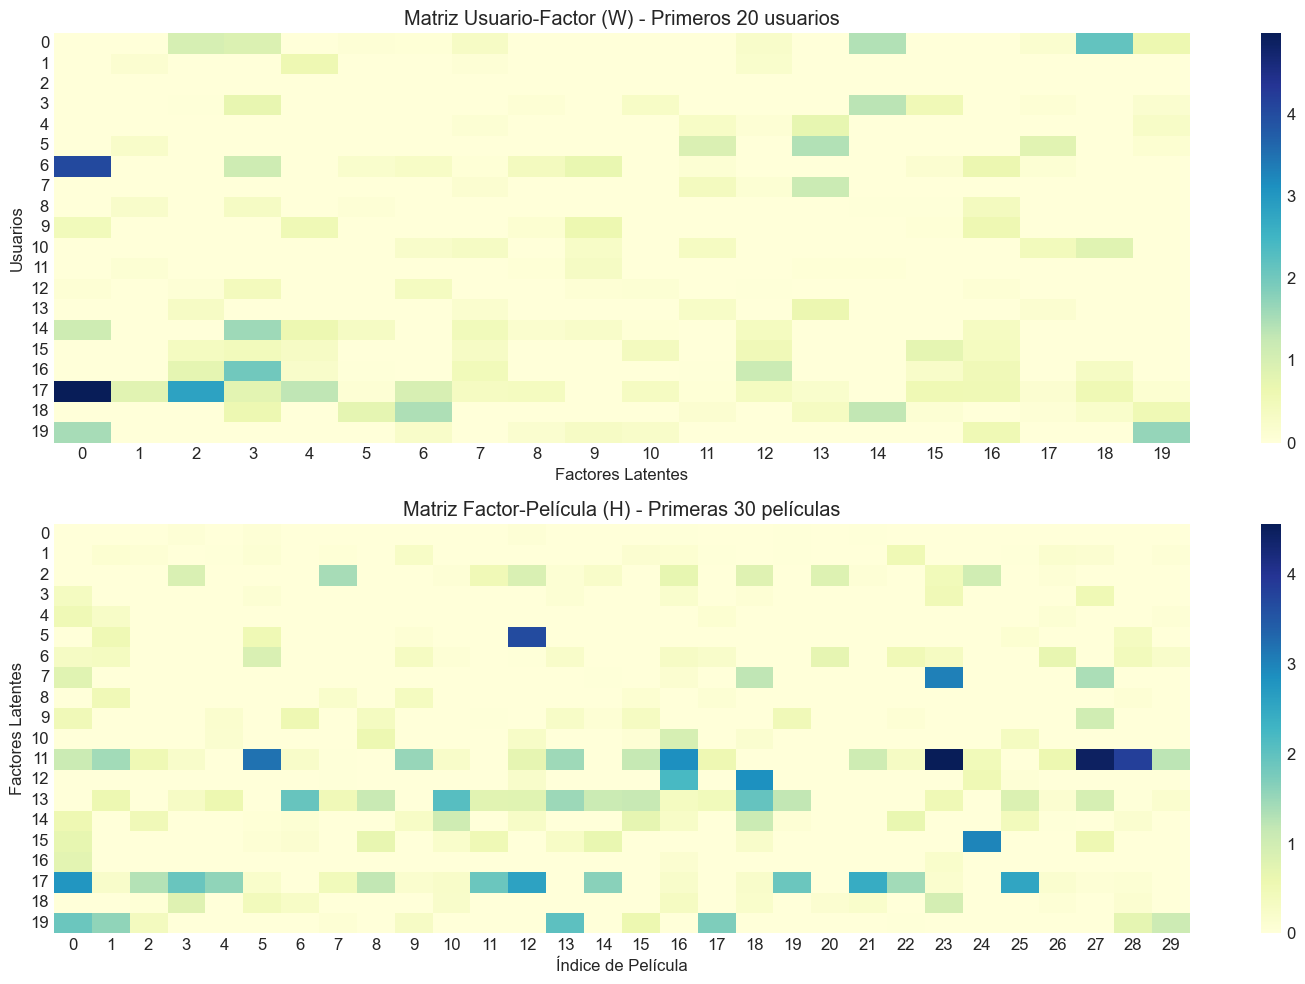

In [170]:
k = 20  
print(f"\nRealizando NNMF con {k} factores latentes...")

X = tabla_filtrada.values

modelo = NMF(n_components=k, init='random', max_iter=1000, random_state=42)
W = modelo.fit_transform(X)  
H = modelo.components_  

print(f"Forma de W (matriz usuario-factor): {W.shape}")
print(f"Forma de H (matriz factor-película): {H.shape}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.heatmap(W[:20, :], cmap="YlGnBu", annot=False)
plt.title('Matriz Usuario-Factor (W) - Primeros 20 usuarios')
plt.xlabel('Factores Latentes')
plt.ylabel('Usuarios')

plt.subplot(2, 1, 2)
sns.heatmap(H[:, :30], cmap="YlGnBu", annot=False)
plt.title('Matriz Factor-Película (H) - Primeras 30 películas')
plt.xlabel('Índice de Película')
plt.ylabel('Factores Latentes')

plt.tight_layout()
plt.savefig('factores_latentes.png')

In [171]:
def recomendador(userId, topVecinos=10, topPeliculas=10):
    
    if userId not in tabla_filtrada.index:
        print(f"Usuario {userId} no encontrado en el conjunto de datos filtrado")
        return None
    
   
    indice_usuario = tabla_filtrada.index.get_loc(userId)
    
    
    factores_usuario = W[indice_usuario].reshape(1, -1)
    
    
    similitudes = cosine_similarity(factores_usuario, W)
    
    
    indices_similares = np.argsort(similitudes[0])[::-1][1:topVecinos+1]
    
    
    ids_usuarios_similares = tabla_filtrada.index[indices_similares]
    print(f"Usuarios más similares al Usuario {userId}: {ids_usuarios_similares.tolist()}")
    
    
    valoraciones_usuario = tabla_filtrada.loc[userId]
    no_vistas = valoraciones_usuario[valoraciones_usuario == 0].index.tolist()
    
    
    if not no_vistas:
        print(f"El Usuario {userId} ha valorado todas las películas en el conjunto de datos filtrado")
        return pd.DataFrame()
    
    
    
    datos_usuarios_similares = tabla_filtrada.loc[ids_usuarios_similares]
    
    
    pesos = similitudes[0][indices_similares]
    pesos = pesos / pesos.sum() 
    
    valoraciones_ponderadas = pd.DataFrame()
    for i, id_usuario in enumerate(ids_usuarios_similares):
        valoraciones_ponderadas[id_usuario] = datos_usuarios_similares.loc[id_usuario] * pesos[i]
    
    
    puntuaciones_recomendacion = valoraciones_ponderadas.sum(axis=1)
    
    puntuaciones_recomendacion = puntuaciones_recomendacion[puntuaciones_recomendacion.index.isin(no_vistas)]
    
    mejores_recomendaciones = puntuaciones_recomendacion.sort_values(ascending=False).head(topPeliculas)
    
    
    valoraciones_reconstruidas = np.dot(W[indice_usuario], H)
    
    valoraciones_predichas = pd.Series(valoraciones_reconstruidas, index=tabla_filtrada.columns)
    
    valoraciones_predichas = valoraciones_predichas[valoraciones_predichas.index.isin(no_vistas)]
    
    recomendaciones_nnmf = valoraciones_predichas.sort_values(ascending=False).head(topPeliculas)
    
    
    print("\nMejores recomendaciones por usuarios similares:")
    recomendaciones_usuarios = mostrar_recomendaciones(mejores_recomendaciones)
    print(recomendaciones_usuarios[['title', 'genres', 'valoracion_predicha']])
    
    print("\nMejores recomendaciones por reconstrucción NNMF:")
    recomendaciones_matriz = mostrar_recomendaciones(recomendaciones_nnmf)
    print(recomendaciones_matriz[['title', 'genres', 'valoracion_predicha']])
    
    
    generos_recomendados = []
    for _, row in recomendaciones_matriz.iterrows():
        generos_pelicula = row['genres'].split('|')
        generos_recomendados.extend(generos_pelicula)
    
    conteo_generos = pd.Series(generos_recomendados).value_counts()
    
    print("\nDistribución de géneros en las recomendaciones:")
    print(conteo_generos)
    
    
    return recomendaciones_matriz

In [173]:
def mostrar_recomendaciones(recomendaciones_series):

    movie_ids = recomendaciones_series.index.tolist()
    movie_scores = recomendaciones_series.values
    
    
    peliculas_recomendadas = movies[movies['movieId'].isin(movie_ids)].copy()
    
    
    movie_id_to_score = dict(zip(movie_ids, movie_scores))
    peliculas_recomendadas['valoracion_predicha'] = peliculas_recomendadas['movieId'].map(movie_id_to_score)
    
    return peliculas_recomendadas.sort_values('valoracion_predicha', ascending=False)



In [174]:
def obtener_mejores_valoraciones_usuario(userId, top=10):
    valoraciones_usuario = ratings[ratings['userId'] == userId]
    
    if valoraciones_usuario.empty:
        print(f"El Usuario {userId} no tiene valoraciones en el conjunto de datos")
        return pd.DataFrame()
    
    mejores_valoraciones = valoraciones_usuario.sort_values('rating', ascending=False).head(top)
    resultado = pd.merge(mejores_valoraciones, movies, on='movieId')
    
    return resultado[['movieId', 'title', 'genres', 'rating']]

In [175]:
usuarios_prueba = [1, 5, 10] 
for usuario in usuarios_prueba:
    print(f"\n{'='*70}")
    print(f"ANÁLISIS DEL USUARIO {usuario}")
    print(f"{'='*70}")
    
    print("\nPelículas mejor valoradas por el usuario:")
    top_valoradas = obtener_mejores_valoraciones_usuario(usuario)
    print(top_valoradas[['title', 'genres', 'rating']])
    
    print("\nGenerando recomendaciones...")
    recomendaciones = recomendador(usuario, topVecinos=15, topPeliculas=10)
    if not top_valoradas.empty and recomendaciones is not None:
        generos_preferidos = []
        for generos in top_valoradas['genres']:
            generos_preferidos.extend(generos.split('|'))
        
        conteo_preferidos = pd.Series(generos_preferidos).value_counts()
        generos_recomendados = []
        for generos in recomendaciones['genres']:
            generos_recomendados.extend(generos.split('|'))
        
        conteo_recomendados = pd.Series(generos_recomendados).value_counts()
        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 1, 1)
        conteo_preferidos.head(10).plot(kind='bar', color='skyblue')
        plt.title(f'Géneros preferidos del usuario {usuario} (Top 10)')
        plt.ylabel('Número de películas')
        plt.xticks(rotation=45, ha='right')
        
        plt.subplot(2, 1, 2)
        conteo_recomendados.head(10).plot(kind='bar', color='lightgreen')
        plt.title(f'Géneros en recomendaciones para usuario {usuario} (Top 10)')
        plt.ylabel('Número de películas')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig(f'comparacion_generos_usuario_{usuario}.png')
        plt.close()



ANÁLISIS DEL USUARIO 1

Películas mejor valoradas por el usuario:
                                         title                        genres  \
0                 M*A*S*H (a.k.a. MASH) (1970)              Comedy|Drama|War   
1                             Excalibur (1981)             Adventure|Fantasy   
2    Indiana Jones and the Last Crusade (1989)              Action|Adventure   
3                  Pink Floyd: The Wall (1982)                 Drama|Musical   
4                 From Russia with Love (1963)     Action|Adventure|Thriller   
5                            Goldfinger (1964)     Action|Adventure|Thriller   
6                      Dirty Dozen, The (1967)              Action|Drama|War   
7                    Gulliver's Travels (1939)  Adventure|Animation|Children   
8                       American Beauty (1999)                 Drama|Romance   
9  South Park: Bigger, Longer and Uncut (1999)      Animation|Comedy|Musical   

   rating  
0     5.0  
1     5.0  
2     5.0  
3   